CNN을 이용한 Fashion MNIST Classification
(출처 : https://team00csduck.tistory.com/232)

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

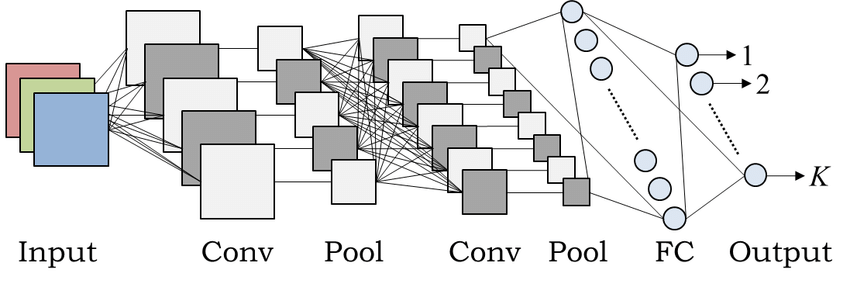

In [3]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)

        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

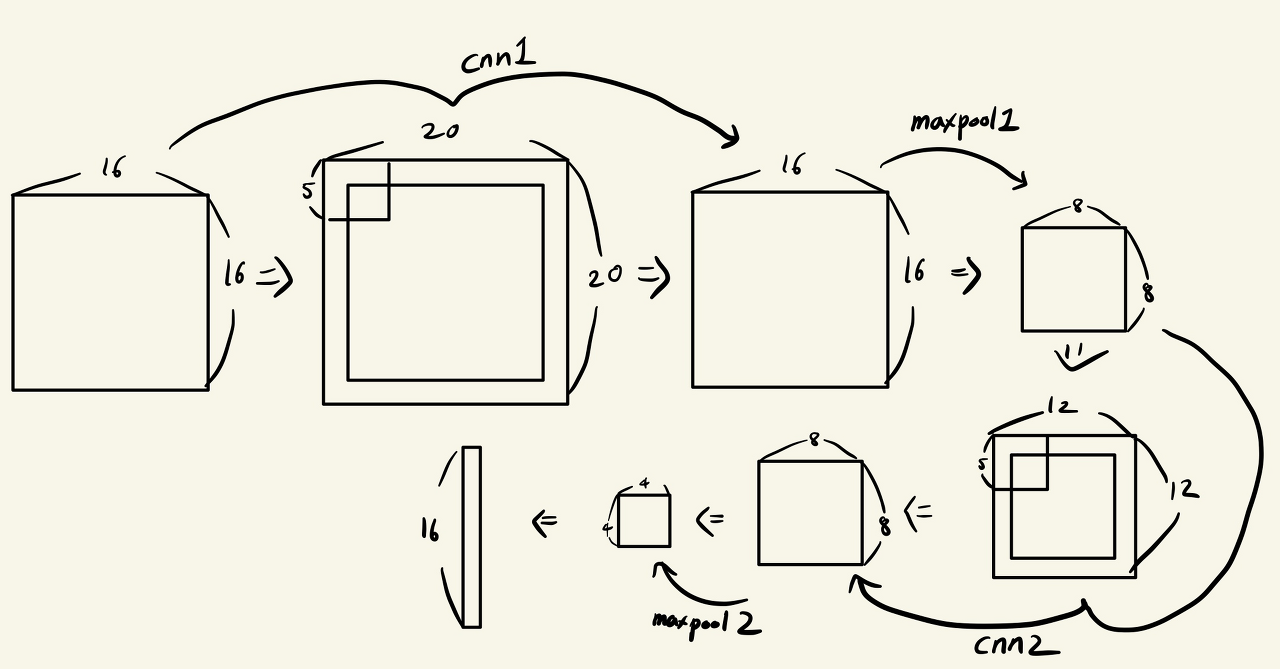

In [4]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

train_dataset = dsets.FashionMNIST(
    root = './data',
    train = True,
    download = True,
    transform = composed
)

validation_dataset = dsets.FashionMNIST(
    root = './data',
    train = False,
    download = True,
    transform = composed
)

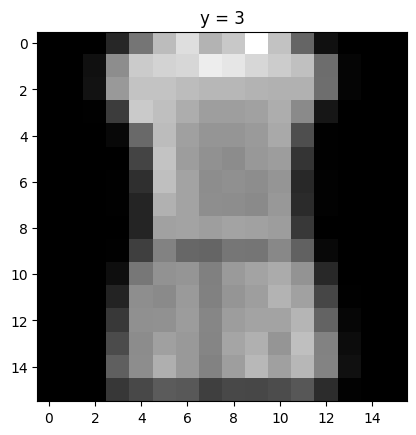

In [5]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

show_data(train_dataset[3])

In [6]:
model = CNN(out_1=16, out_2=32)
model.eval()

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [8]:
n_epochs=10
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        print(f"{epoch+1}/{n_epochs}")
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data

        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)

train_model(n_epochs)

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


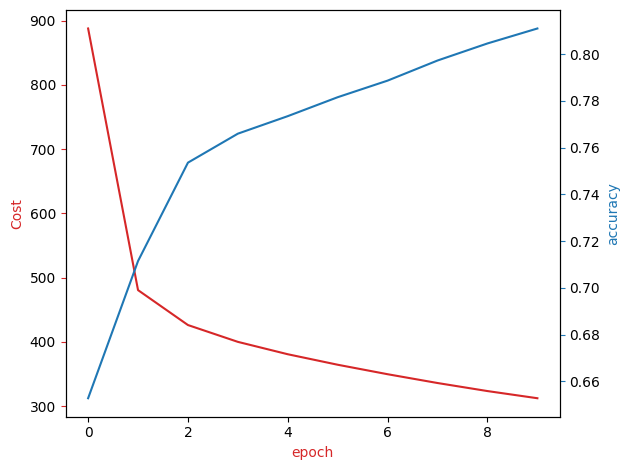

In [9]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

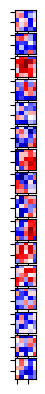

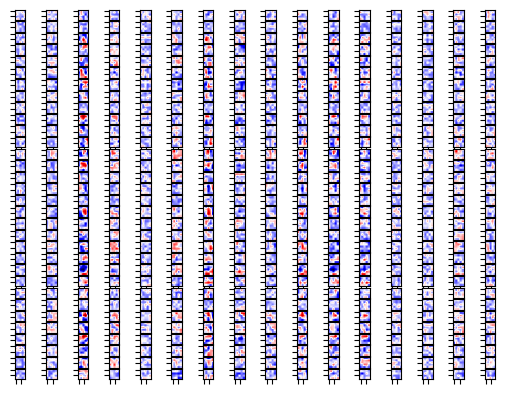

In [10]:
def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0

    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()


plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])